# Veg-GAN:

#### Veg-GAN is a Wasserstein GAN that uses gradient penalty
#### It is trained on opensource data of plants from google apis Open Images Dataset V6.
#### Data is not normalized and is real world data.
#### Also, Veg-GAN is punny because it not only is a vegetation GAN,
#### it is also punny because WGANs are pronounced as VGAN

In [ ]:
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# this is to check if the gpu is present
print(device_lib.list_local_devices())


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
from multiprocessing import Pool
import imageio
import cv2

from tensorflow.keras.layers import Conv2D, Dense, Flatten, UpSampling2D, Input
from tensorflow.keras.layers import Reshape, LayerNormalization, BatchNormalization, AveragePooling2D, ReLU
from tensorflow.keras.optimizers import Adam


In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.threading.set_intra_op_parallelism_threads(1)


In [5]:
policy = tf.keras.mixed_precision.Policy("float32")  # "mixed_float16"


In [6]:
DATA_PATH = './images/'  # Path to dataset of opensource image dataset
Z_DIM = 256
GENERATOR_DENSE_SIZE = 64*8  # Length of first tensor in generator
IMAGE_SIZE = 64
BATCH_SIZE = 32


In [ ]:
# helper functions
def get_image(image_path, image_size=64, is_crop=True):
    return transform(imread(image_path), image_size, is_crop)


def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)


def imread(path):
    return imageio.imread(path).astype(np.float)


def merge_images(images, size):
    return inverse_transform(images)


def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((int(h * size[0]), int(w * size[1]), 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img


def imsave(images, size, path):
    img = merge(images, size)
    return imageio.imwrite(path, (255*img).astype(np.uint8))


def transform(image, npx=250, is_crop=True):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1.


def inverse_transform(images):
    return (images+1.)/2.


def center_crop(x, crop_h, crop_w=None):
    # I take the smallest dimension between height and width, find the center of the image, and crop to the largest possible square
    # Then I resize to desired image size.
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]

    if h > w:
        result = cv2.resize(
            x[int(h/2 - w/2):int(h/2 + w/2), :], (crop_h, crop_w))
    else:
        result = cv2.resize(
            x[:, int(w/2 - h/2):int(w/2 + h/2)], (crop_h, crop_w))

    return result


In [7]:
assert(os.path.exists(DATA_PATH)
       ), 'Make sure you have your images in the right place'


In [ ]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"


# An example of the training data

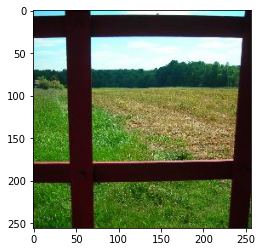

In [ ]:
plt.imshow((get_image(data[11], 256) + 1)/2)


# Model Definitions

In [14]:
DIM = 64


class Generator_residual_block(tf.keras.layers.Layer):
    # in: (n,n, filters) out: (2n, 2n, filters)
    def __init__(self, output_dim, filter_size=3):
        super(Generator_residual_block, self).__init__()
        self.shortcut_upsample = UpSampling2D(
            size=(2, 2), interpolation="nearest")
        self.shortcut_upsample_conv = Conv2D(
            output_dim, (3, 3), strides=(1, 1), padding="same")

        self.batch_norm1 = BatchNormalization()
        self.activation1 = ReLU()
        self.upsample = UpSampling2D(size=(2, 2), interpolation="nearest")
        self.conv1 = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", use_bias=False)

        self.batch_norm2 = BatchNormalization()
        self.activation2 = ReLU()
        self.conv2 = Conv2D(
            output_dim, (filter_size, filter_size), strides=(1, 1), padding="same")

        self.batch_norm3 = BatchNormalization()
        self.activation3 = ReLU()

        self.conv_q = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")
        self.conv_k = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")
        self.conv_v = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")

    @tf.function
    def call(self, x):
        shortcut = self.shortcut_upsample(x)
        shortcut = self.shortcut_upsample_conv(shortcut)
        out = self.batch_norm1(x)
        out = self.activation1(out)
        out = self.upsample(out)
        out = self.conv1(out)
        out = self.batch_norm2(out)
        out = self.activation2(out)
        out = self.conv2(out)
        out_ = self.batch_norm3(out)
        out_ = self.activation3(out_)
        q = self.conv_q(out_)
        k = self.conv_k(out_)
        v = self.conv_v(out_)

        score = tf.matmul(q, k, transpose_b=True)
        score = tf.keras.activations.softmax(score)
        attention_out = tf.matmul(score, v)

        return attention_out + out + shortcut


class Generator(tf.keras.Model):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.input_layer = Input(shape=(128,))
        self.dense1 = Dense(dim*4*4*8)

        self.reshape = Reshape((4, 4, 8*dim))

        self.residual_block1 = Generator_residual_block(8*dim)  # 8,8,128
        self.residual_block2 = Generator_residual_block(4*dim)  # 16,16,128
        self.residual_block3 = Generator_residual_block(2*dim)  # 32,32,128
        self.residual_block4 = Generator_residual_block(dim)  # 64,64,128

        self.batch_norm = BatchNormalization()  # vegGAN
        # self.batch_norm = LayerNormalization() #celebA
        self.activation = ReLU()
        self.final_conv = Conv2D(
            3, (3, 3), padding="same", activation="tanh", dtype="float32")

    @tf.function
    def call(self, z):
        x = self.dense1(z)
        x = self.reshape(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.residual_block4(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return self.final_conv(x)


class Critic_residual_block(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, downsample=True, filter_size=3):
        super(Critic_residual_block, self).__init__()

        self.layer_norm1 = LayerNormalization()
        self.activation1 = ReLU()
        self.conv1 = Conv2D(
            input_dim, (filter_size, filter_size), strides=(1, 1), padding="same")

        self.layer_norm2 = LayerNormalization()
        self.activation2 = ReLU()
        self.conv2 = Conv2D(
            output_dim, (filter_size, filter_size), strides=(1, 1), padding="same")

        self.downsample = downsample
        if downsample:
            self.conv2_pool = AveragePooling2D(pool_size=(2, 2))
            self.shortcut_pool_conv = Conv2D(
                output_dim, (3, 3), strides=(1, 1), padding="same")
            self.shortcut_pool = AveragePooling2D(pool_size=(2, 2))
        self.layer_norm3 = LayerNormalization()
        self.activation3 = ReLU()
        self.conv_q = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")
        self.conv_k = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")
        self.conv_v = Conv2D(output_dim, (filter_size, filter_size), strides=(
            1, 1), padding="same", activation="relu")

    @tf.function(jit_compile=True)
    def call(self, x):
        if self.downsample:
            shortcut = self.shortcut_pool_conv(x)
            shortcut = self.shortcut_pool(shortcut)
        else:
            shortcut = x
        x = self.layer_norm1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.layer_norm2(x)
        x = self.activation2(x)
        x = self.conv2(x)
        if self.downsample:
            x = self.conv2_pool(x)

        x_ = self.layer_norm3(x)
        x_ = self.activation3(x_)
        q = self.conv_q(x_)
        k = self.conv_k(x_)
        v = self.conv_v(x_)

        score = tf.matmul(q, k, transpose_b=True)
        score = tf.keras.activations.softmax(score)
        attention_out = tf.matmul(score, v)

        return attention_out + x + shortcut


class Critic(tf.keras.Model):
    def __init__(self, dim):
        super(Critic, self).__init__()  # 256,256, 3

        self.conv1 = Conv2D(dim, (3, 3), strides=(1, 1), padding="same")
        self.activation0 = ReLU()
        self.conv2 = Conv2D(2*dim, (3, 3), strides=(1, 1), padding="same")
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))
        self.shortcut_avg_pool = AveragePooling2D(pool_size=(2, 2))
        self.conv_shortcut = Conv2D(
            2*dim, (3, 3), strides=(1, 1), padding="same")

        self.residual_block1 = Critic_residual_block(2*dim, 4*dim)  # 16,16,128
        self.residual_block2 = Critic_residual_block(4*dim, 8*dim)  # 8,8,128
        self.residual_block3 = Critic_residual_block(8*dim, 8*dim)  # 8,8,128
        self.activation = ReLU()
        self.final_pool = Flatten()
        self.dense = Dense(1, activation="linear",
                           dtype="float32", use_bias=False)

    @tf.function(jit_compile=True)
    def call(self, x):
        output = self.conv1(x)
        output = self.activation0(output)
        output = self.conv2(output)
        output = self.avg_pool(output)
        shortcut = self.shortcut_avg_pool(x)
        shortcut = self.conv_shortcut(shortcut)
        output = output + shortcut
        x = self.residual_block1(output)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.activation(x)
        x = self.final_pool(x)
        return self.dense(x)


In [ ]:
generator = Generator(DIM)
critic = Critic(DIM)
# to build models for summary & compile
gen_out = generator(tf.random.normal((1, Z_DIM)))
critic(gen_out)


In [16]:
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1056768   
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
generator_residual_block (Ge multiple                  14164480  
_________________________________________________________________
generator_residual_block_1 ( multiple                  4723968   
_________________________________________________________________
generator_residual_block_2 ( multiple                  1182336   
_________________________________________________________________
generator_residual_block_3 ( multiple                  296256    
_________________________________________________________________
batch_normalization_12 (Batc multiple                  25

In [17]:
critic.summary()


Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           multiple                  1792      
_________________________________________________________________
re_lu_13 (ReLU)              multiple                  0         
_________________________________________________________________
conv2d_26 (Conv2D)           multiple                  73856     
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
conv2d_27 (Conv2D)           multiple                  3584      
_________________________________________________________________
critic_residual_block (Criti multiple                  25091

In [18]:
@tf.function(jit_compile=True)
def critic_loss(real_output, fake_output):
    # WGAN -- returns seperately for metrics, Gradient Penalty will be included during training
    d_loss_real = tf.reduce_mean(real_output)
    d_loss_fake = tf.reduce_mean(fake_output)
    return d_loss_real, d_loss_fake


@tf.function(jit_compile=True)
def generator_loss(fake_output):
    # WGANGP loss
    g_loss = -tf.reduce_mean(fake_output)
    return g_loss


In [19]:
# WGANGP
@tf.function(jit_compile=True)
def gradient_penalty(critic, real_images, fake_images):
    batch_size, h, w, c = real_images.shape
    epsilon = tf.random.uniform((batch_size, 1, 1, 1), 0, 1)
    interpolated_images = real_images * epsilon + fake_images * (1 - epsilon)
    with tf.GradientTape() as t:
        t.watch(interpolated_images)
        interpolated_scores = critic(interpolated_images)
    gradients = t.gradient(interpolated_scores, interpolated_images)
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2, 3]))
    d_regularizer = tf.reduce_mean((ddx - 1) ** 2)
    return d_regularizer


In [20]:
# # #WGANGP suggested parameters
LEARNING_RATE_C = 3e-4
LEARNING_RATE_G = 1e-4

BETA_1 = 0
BETA_2 = 0.9
c_optimizer = Adam(learning_rate=LEARNING_RATE_C, beta_1=BETA_1, beta_2=BETA_2)
g_optimizer = Adam(learning_rate=LEARNING_RATE_G, beta_1=BETA_1, beta_2=BETA_2)


In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 critic_optimizer=c_optimizer,
                                 generator=generator,
                                 critic=critic)


In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [24]:
c_optimizer.beta_1 = tf.cast(0, tf.float32)
g_optimizer.beta_1 = tf.cast(0, tf.float32)


In [25]:
import imageio

EPOCHS = 50

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([BATCH_SIZE, Z_DIM])


In [26]:
MERGE_X = 8  # 4 # the number of images in a row for the saved grid of images


def generate_and_save_images(model, epoch, batch_num, test_input):

    predictions = model(test_input, training=False)
    MERGE_Y = BATCH_SIZE//MERGE_X
    save_images(predictions, [
                MERGE_X, MERGE_Y], "./Generated_images/image_at_epoch_{:04d}_batch_{:04d}.jpg".format(epoch, batch_num))


In [74]:
generate_and_save_images(generator, 0, 0, seed)


In [29]:
g_loss = tf.keras.metrics.Mean(name="generator_loss")
c_loss_real = tf.keras.metrics.Mean(name="critic_loss_real")
c_loss_fake = tf.keras.metrics.Mean(name="critic_loss_fake")


In [30]:
LAMBDA = 10  # WGANGP SUGGESTED PARAMETER


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = critic(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))

    g_loss(gen_loss)


@tf.function
def critic_step(images):
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as crit_tape:
        generated_images = generator(noise, training=True)

        real_output = critic(images, training=True)
        fake_output = critic(generated_images, training=True)

        crit_loss_real, crit_loss_fake = critic_loss(real_output, fake_output)
        crit_loss = crit_loss_fake - crit_loss_real + LAMBDA * \
            gradient_penalty(critic, images, generated_images)

    gradients_of_critic = crit_tape.gradient(
        crit_loss, critic.trainable_variables)
    c_optimizer.apply_gradients(
        zip(gradients_of_critic, critic.trainable_variables))

    c_loss_real(crit_loss_real)
    c_loss_fake(crit_loss_fake)


In [31]:
N_CRITIC = 1  # number of additional steps of the critic for each training step of the generator


def train(epochs):
    # Multiprocessing here was more performant than using a generator or tf.data
    pool = Pool(8)
    for epoch in range(epochs):
        start = time.time()

        batch_idxs = len(data) // BATCH_SIZE
        for idx in range(0, batch_idxs):

            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = pool.map(get_image, batch_files)
            batch_images = np.array(batch).astype(np.float32)

            # WGANGP -- needs to train critic to optimality
            for _ in range(N_CRITIC):
                critic_step(batch_images)
            #
            train_step(batch_images)
            if idx % 100 == 0:
                print(
                    f"Epoch {epoch+0} Batch [{idx}/{batch_idxs}] g_loss: {g_loss.result():.5f}, c_loss_real: {c_loss_real.result():.5f}, c_loss_fake: {c_loss_fake.result():.5f}")

            if idx % 200 == 0:
                generate_and_save_images(generator, epoch+0, idx, seed)

        checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 0, time.time()-start))

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, 0, seed)


In [ ]:
train(EPOCHS)


In [ ]:
# for saving models
# note: model is not compiled so optimizer state is not retained,
# however this is not a problem because we do not use momentum

generator.save("./models/VegGAN_generator")
critic.save("./models/VegGAN_critic")


In [ ]:
generator.save("./models/celebA_generator")
critic.save("./models/celebA_critic")


In [28]:
anim_file = './Generated_images/VegGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob('./Generated_images/image*.jpg')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
